# Определение возраста по фотографии

Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста из датасета [appa-real-face-cropped](https://www.kaggle.com/datasets/abhikjha/appa-real-face-cropped). На нём будем тренировать модель. В конце протестируем на реальных личных фотографиях. 

Последовательность решения задачи:
1. Загрузка и исследование данных.
2. Подготовка данных к обучению модели.
3. Построение модели. Для решения данной задачи применим модель на основе нейросети.
4. Анализ работы модели и вывод.

In [7]:
# Импорт библиотек
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [6]:
import face_recognition

In [8]:
PATH = '/kaggle/input/appa-real-face-cropped/final_files/final_files/'
PATH_FR = '/kaggle/working/appa-real-face-recognition/final_files/final_files/'

## Исследовательский анализ данных

1. Загрузим набор данных.
2. Проанализируем данные.
3. Проанализируем фотографии.

In [9]:
# Загрузка набора данных
df = pd.read_csv('/kaggle/input/appa-real-face-cropped/labels.csv')

In [10]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [11]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


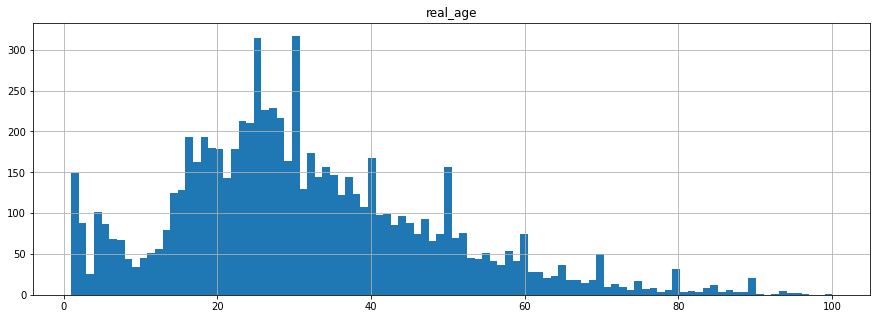

In [12]:
# Гистограма распределения возраста
df.hist(bins=100, figsize=(15,5));

In [13]:
# Посмотрим подробнее на наименее представительные возраста
df['real_age'].value_counts().tail(20)

84     8
77     8
76     7
87     6
79     6
74     6
94     5
82     5
89     4
78     3
86     3
83     3
88     3
81     3
95     2
96     2
100    1
97     1
93     1
91     1
Name: real_age, dtype: int64

In [14]:
# Количество дубликатов
df.duplicated().sum()

0

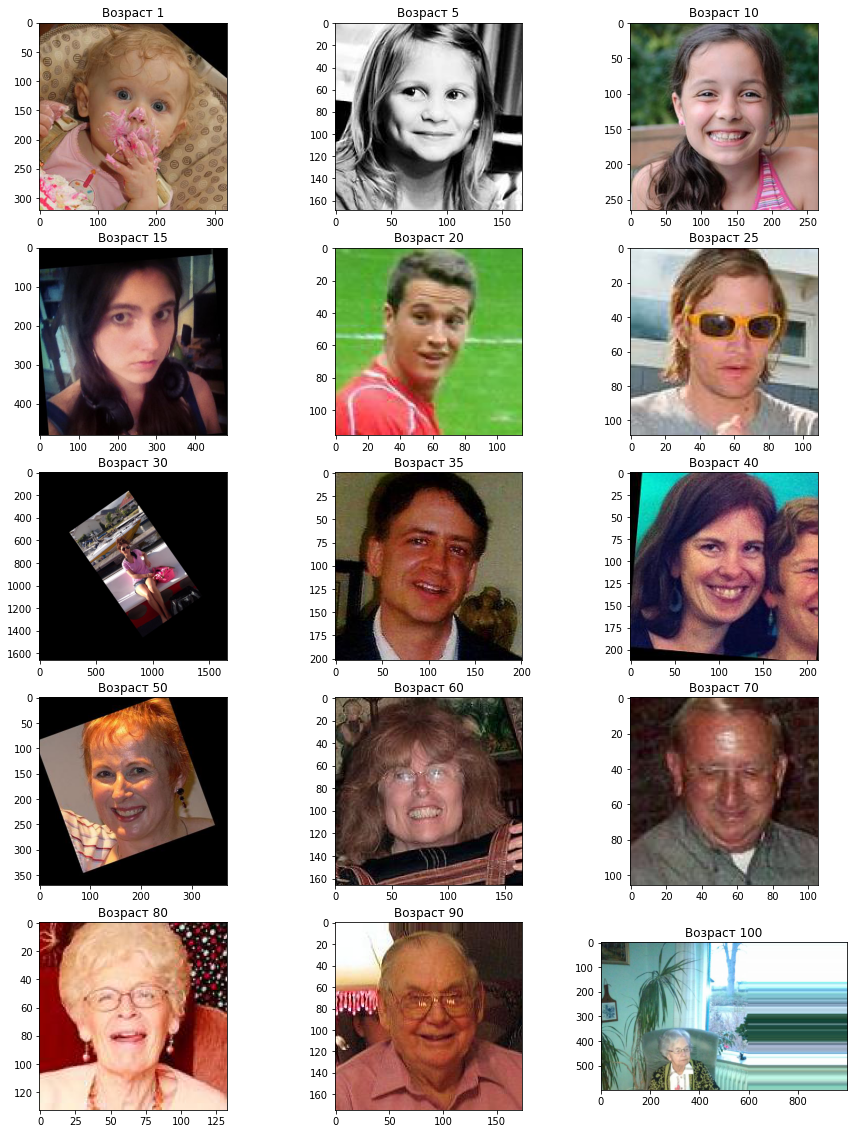

In [19]:
# Выделим по одной фотографии каждого возраста
one_file_age = df.groupby('real_age')['file_name'].min()
# Выберем возраст, фотограйии которого будем выводить на экран
selected_age = [1,5,10,15,20,25,30,35,40,50,60,70,80,90,100]

# Вывод на экран 12 фотографий
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,20))

n = 0
for ax in axes.flat:
    ax.set(title=(f'Возраст {selected_age[n]}'))
    image = Image.open(PATH + one_file_age[selected_age[n]])
    ax.imshow(image)
    n += 1
plt.show()

**Вывод**

1. Набор данных содержит 7591 фотографию. Данного количества может не хватить для обучения нейросети. Для увеличения выборки, на этапе предобработки применим добавление аугментаций.
2. Пропусков и дубликатов в данных нет.
3. Анализ возраста в датасете:
    - Диапозон возрастов от 1 до 100 лет.
    - Средний возраст 31 год, медианный 29.
    - Большая часть возрастов людей на представленных фотографиях лежит в диапозоне от 20 до 40 лет.
    - Люди старшего возраста в наборе данных представленны достаточно слабо: по 1-5 фотографий. Это связано с тем, что фотографии собирались из общедоступных интернет-хранилищ, где наиболее представленны именно молодые люди. Данный факт может стать фактором, ухудшающим качество будущей модели. Частичному решению данной проблемы, также послужит добавление аугментаций.
    - На гистограмме наблюдаются пики в районе круглых десятков лет. Это может быть связано с тем, что в наборе данных присутствуют как реальные данные о возрасте, так и данные полученные путём разметки возраста методом оценки кажущегося возраста несколькими оценщиками. Видимо чаще всего оценщики определяли возраст с точностью 10 лет. Думаю, это не должно сильно повлиять на работу модели.
4. Анализ фотографий:
    - Фотографии в наборе данных имеют разный размер.
    - Большенство фотографий предобработаны. В них изменёи угол поворота и произведена обрезка по размеру лица. Это положительно повлияет на качество обучения модели. Однако, на некоторых фотографиях лица людей занимают лишь малую часть фотографии. Поэтому будущая модель будет обучатся не столько -на лицах людей, сколько на окружающей обстановке, которая не имеет отношения к возрасту человека. Например единственная 100--летняя бабушка сидит в углу фотографии, и её лицо занимает менее 5% фотографии.
    - Также, встречаются фотографии, где в кадр попадают и лица других людей, что может негативно сказаться на качестве модели.

## Подготовка данных и обучение модели

1. Для решения проблем с качеством фотографий, применим модель детекции лиц из библиотеки `face_recognition`.
2. Создадим необходимые функции для загрузки данных и обучения модели.

Для обучения модели в тренажёре ЯП на GPU, создадим необходимые функции:
1. `load_train`. Функция будет возвращать загрузчик тренировачного набора даннных. В данном загрузчике изображения будут приводится к одному размеру. Также, для увеличения тренировочной выборки и частичного решения проблемы наличия малого количества фотографий людей старшего возраста, добавим аугментации в тренировочные данные. Думаю, к изображениям лиц, будет допустимо применить смещения и поворот по горизонтали. 
2. `load_valid`. Функция будет возвращать загрузчик валидационного набора даннных. Аугментации в тестовые данные добавлять не будем.
2. `load_test`. Функция будет возвращать загрузчик трестового набора даннных(реальные фотографии).
3. `create_model`. Функция будет возвращать модель. Создание нейросетевой модели с нуля считаю не целесообразным, поэтому создавать модель будем на основе существующих архитектур. Для построения модели будем использовать модель с архитектурой `ResNet50` из библиотеки Keras. Вместо последних двух слоёв `ResNet50` добавим слои:
    - GlobalAveragePooling2D - для усреднения информации по всему изображению на выходе из ResNet50;
    - Dense(64, activation='relu') - для снижения размерности признаков;
    - Dense(1, activation='relu') - выходной слой, выдающий значение прогнозируемого возраста.
    
    Компиляцию модели осуществим со следующими параметрами:
    - Оптимизатор `Adam` или `Adamax`, а также его параметр `learning_rate` подоберём опытным путём;
    - Функцию потерь `MSE`;
    - Метрику качества `MAE`
4. `train_model`. Функция будет обучать модель и возвращать модель после обучения. Оптимальное количество эпох обучения, подберём опытным путём.

## Детекция лиц

1. Обработаем фотографии с помощью библиотеки Face_recognition.
2. Оценим результат

In [16]:
# Создадим новую папку для распознанных лиц на фотографии
os.makedirs(PATH_FR)

In [17]:
def face_rec(filename, input_path=PATH, output_path=PATH_FR):
    """ Принимаем имя файла
        Сохраняем в файл распознанное лицо
        Возвращаем True если лицо было распознано, False если лица нет, либо если лиц больше 1
    """
    fr_image = face_recognition.load_image_file(input_path + filename)
    face_locations = face_recognition.face_locations(fr_image)
    if len(face_locations) != 1:
        return False
        
    top, right, bottom, left = face_locations[0]
    face_image = fr_image[top:bottom, left:right]
    pil_image = Image.fromarray(face_image)
    pil_image.save(output_path + filename)
    
    return True

In [20]:
df['face_rec'] = df['file_name'].apply(face_rec)

In [22]:
df['face_rec'].value_counts()

True     7157
False     434
Name: face_rec, dtype: int64

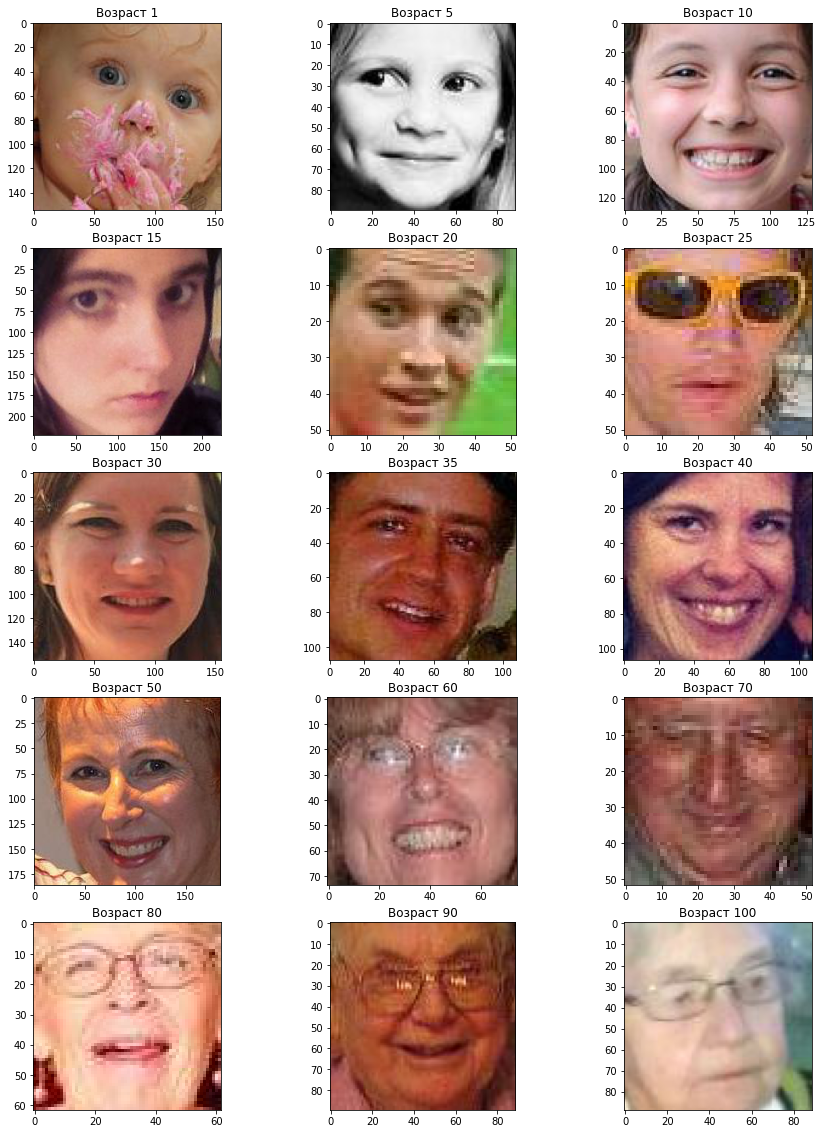

In [24]:
# Посмотрим на лица после детекции
one_file_age = df[df['face_rec']].groupby('real_age')['file_name'].min()
# Выберем возраст, фотограйии которого будем выводить на экран
selected_age = [1,5,10,15,20,25,30,35,40,50,60,70,80,90,100]

# Вывод на экран 12 фотографий
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,20))

n = 0
for ax in axes.flat:
    ax.set(title=(f'Возраст {selected_age[n]}'))
    image = Image.open(PATH_FR + one_file_age[selected_age[n]])
    ax.imshow(image)
    n += 1
plt.show()

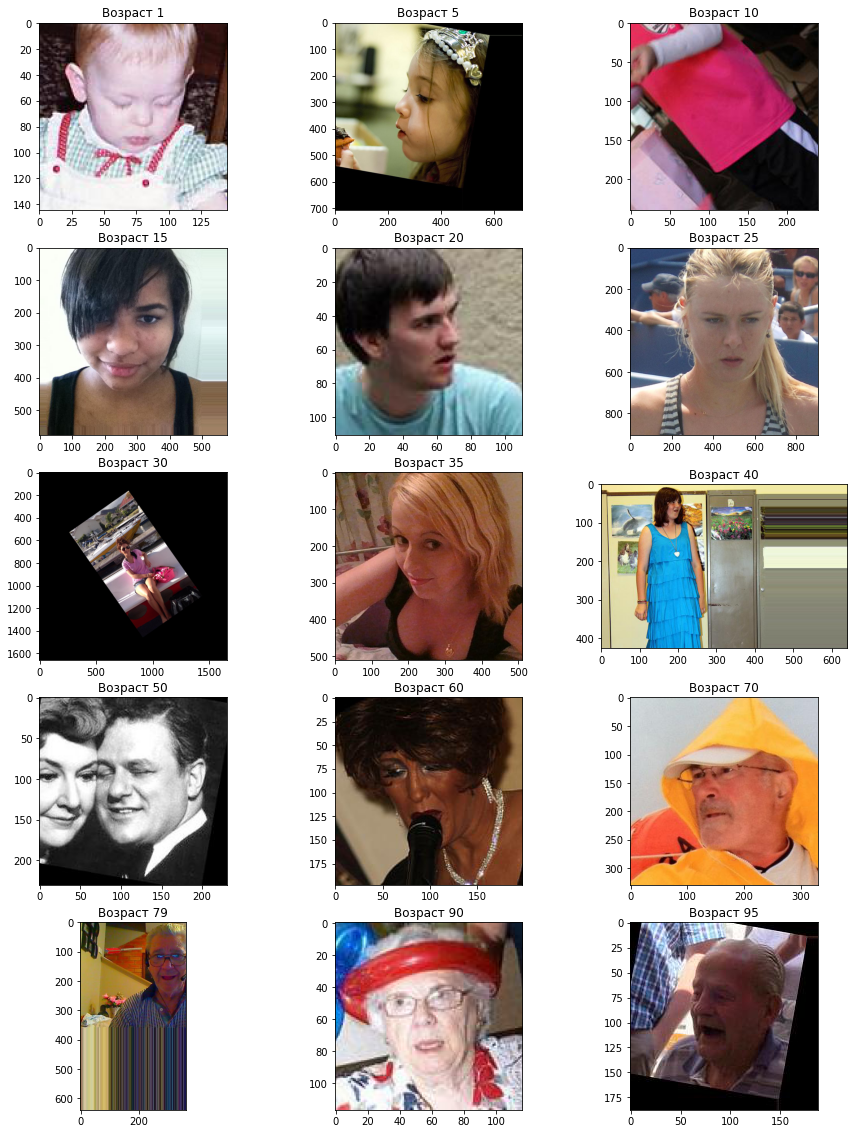

In [25]:
# Посмотрим на отбракованные фотографии
one_file_age = df[df['face_rec'] == False].groupby('real_age')['file_name'].min()
# Выберем возраст, фотограйии которого будем выводить на экран
selected_age = [1,5,10,15,20,25,30,35,40,50,60,70,79,90,95]

# Вывод на экран 12 фотографий
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,20))

n = 0
for ax in axes.flat:
    ax.set(title=(f'Возраст {selected_age[n]}'))
    image = Image.open(PATH + one_file_age[selected_age[n]])
    ax.imshow(image)
    n += 1
plt.show()

**Вывод:**

- Из 7591 фотографии 434 были отбракованы по причине отсутствия лица на на фото, лица низкого качества, частично перекрытого и т.д. 
- Из остальных фотографий получены только лица крупным планом.

## Подготовка данных и обучение модели

Для обучения модели, создадим необходимые функции:
1. `load_train`. Функция будет возвращать загрузчик тренировачного набора даннных. В данном загрузчике изображения будут приводится к одному размеру. Также, для увеличения тренировочной выборки и частичного решения проблемы наличия малого количества фотографий людей старшего возраста, добавим аугментации в тренировочные данные. Думаю, к изображениям лиц, будет допустимо применить смещения и поворот по горизонтали. 
2. `load_valid`. Функция будет возвращать загрузчик валидационного набора даннных. Аугментации в тестовые данные добавлять не будем.
2. `load_test`. Функция будет возвращать загрузчик трестового набора даннных(реальные фотографии).
3. `create_model`. Функция будет возвращать модель. Создание нейросетевой модели с нуля считаю не целесообразным, поэтому создавать модель будем на основе существующих архитектур. Для построения модели будем использовать модель с архитектурой `ResNet50` из библиотеки Keras. Вместо последних двух слоёв `ResNet50` добавим слои:
    - GlobalAveragePooling2D - для усреднения информации по всему изображению на выходе из ResNet50;
    - Dense(64, activation='relu') - для снижения размерности признаков;
    - Dense(1, activation='relu') - выходной слой, выдающий значение прогнозируемого возраста.
    
    Компиляцию модели осуществим со следующими параметрами:
    - Оптимизатор `Adam` или `Adamax`, а также его параметр `learning_rate` подоберём опытным путём;
    - Функцию потерь `MSE`;
    - Метрику качества `MAE`
4. `train_model`. Функция будет обучать модель и возвращать модель после обучения. Оптимальное количество эпох обучения, подберём опытным путём.

In [26]:
def load_train(path, labels):
    """ Принимаем путь к папке.
        Возвращаем загрузчик тренировочных данных.
    """
    datagen = ImageDataGenerator(validation_split=0.25, 
                                 rescale=(1/255),
                                 horizontal_flip=True,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2
                                )
    
    train_datagen_flow = datagen.flow_from_dataframe(
                                dataframe=labels,
                                directory=path,
                                x_col='file_name',
                                y_col='real_age',
                                target_size=(224, 224),
                                batch_size=32,
                                class_mode='raw',
                                subset='training',
                                seed=12345)
    print('train shape =', len(train_datagen_flow.filenames))
    return train_datagen_flow

In [27]:
def load_valid(path, labels):
    """ Принимаем путь к папке.
        Возвращаем загрузчик тестовых данных.
    """
    datagen = ImageDataGenerator(validation_split=0.25, rescale=(1/255))
    
    valid_datagen_flow = datagen.flow_from_dataframe(
                                dataframe=labels,
                                directory=path,
                                x_col='file_name',
                                y_col='real_age',
                                target_size=(224, 224),
                                batch_size=32,
                                class_mode='raw',
                                subset='validation',
                                seed=12345)
    print('valid shape =', len(valid_datagen_flow.filenames))
    return valid_datagen_flow

In [28]:
def load_all(path, labels):
    """ Принимаем путь к папке.
        Возвращаем загрузчик тренировочных данных.
    """
    datagen = ImageDataGenerator(rescale=(1/255),
                                 horizontal_flip=True,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2
                                )
    
    train_datagen_flow = datagen.flow_from_dataframe(
                                dataframe=labels,
                                directory=path,
                                x_col='file_name',
                                y_col='real_age',
                                target_size=(224, 224),
                                batch_size=32,
                                class_mode='raw',
                                seed=12345)
    print('train shape =', len(train_datagen_flow.filenames))
    return train_datagen_flow

In [29]:
def load_test(path):
    """ Принимаем путь к папке.
        Возвращаем загрузчик тестовых данных.
    """
    datagen = ImageDataGenerator(rescale=(1/255))
    
    test_datagen_flow = datagen.flow_from_directory(
                                directory=path,
                                shuffle=False,
#                                 x_col='file_name',
#                                 y_col='real_age',
                                target_size=(224, 224),
#                                 batch_size=32,
#                                 class_mode='sparse',
#                                 subset='validation',
#                                 seed=12345
                                )
#     print('predict shape =', len(test_datagen_flow.filenames))
    return test_datagen_flow

In [30]:
def predict_model(model, predict_datagen):
    """ Принимаем модель, данные и параметры для обучения модели.
        Возвращаем обученную модель.
    """
    return model.predict(predict_datagen, 
                          #validation_data=test_datagen,
                          #batch_size=batch_size, 
                          #epochs=epochs,
                          #steps_per_epoch=steps_per_epoch,
                          #validation_steps=validation_steps,
                          verbose=2, 
                          #shuffle=True
                             )

     

In [43]:
def create_model(input_shape):
    """ Принимаем размер входных данных.
        Возвращаем модель.
    """
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    # backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu'))
    optimizer = Adamax(learning_rate=0.0004)

    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    model.summary()
    return model

In [32]:
def train_model(model, train_datagen, test_datagen, batch_size=16, epochs=15,
               steps_per_epoch=None, validation_steps=None):
    """ Принимаем модель, данные и параметры для обучения модели.
        Возвращаем обученную модель.
    """
    model.fit(train_datagen, 
              validation_data=test_datagen,
              #batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

## Обучение модели

In [44]:
model = train_model(create_model((224,224,3)),
                    train_datagen = load_train(PATH_FR, df[df['face_rec']]),
                    test_datagen = load_valid(PATH_FR, df[df['face_rec']]), 
                    epochs=16,
                   )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                131136    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 23,718,913
Trainable params: 23,665,793
Non-trainable params: 53,120
_________________________________________________________________
Found 5368 validated image filenames.
train shape = 5368
Found 1789 validated image filenames.
valid shape = 1789
Epoch 1/16
168/168 - 79s - loss: 205.2296 - mae: 10.7157 - val_loss: 517.5996 - val_mae: 17.6762
Epoch 2/16
168/168 - 74s

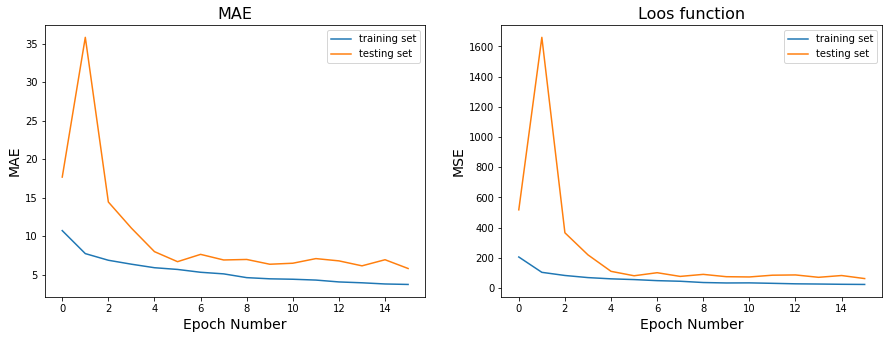

In [45]:
# Визуализация процесса обучения модели
fig = plt.figure(figsize=(15,5))

ax_1 = fig.add_subplot(1, 2, 1)
ax_1.set_title('MAE', fontsize=16)
ax_1.set_xlabel('Epoch Number', fontsize=14)
ax_1.set_ylabel('MAE', fontsize=14)
ax_1 = plt.plot(model.history.history['mae'], label='training set')
ax_1 = plt.plot(model.history.history['val_mae'], label='testing set')
plt.legend();

ax_2 = fig.add_subplot(1, 2, 2)
ax_2.set_title('Loos function', fontsize=16)
ax_2.set_xlabel('Epoch Number', fontsize=14)
ax_2.set_ylabel('MSE', fontsize=14)
ax_2 = plt.plot(model.history.history['loss'], label='training set')
ax_2 = plt.plot(model.history.history['val_loss'], label='testing set')

plt.legend();

**Вывод**

Метрика МАЕ на тестовом наборе данных составила 5.8. Таким образом, достигнуто необходимое качество модели. Опытным путём были подобраны:

- Оптимизатор Adamax;
- Параметр оптимизатора learning_rate=0.0004;
- Количество эпох = 16

## Сохранение обученной модели 

1. Обучим модель на всём датасете.
2. Посмотрим как модель отработает на моих личных фоторгафиях.
3. Сохраним модель для использования в скрипте телеграм-бота

In [46]:
model_all = train_model(create_model((224,224,3)),
                    train_datagen = load_all(PATH_FR, df),
                    test_datagen = None, 
                    #batch_size=32,
                    epochs=16,
                   )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                131136    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 23,718,913
Trainable params: 23,665,793
Non-trainable params: 53,120
_________________________________________________________________
Found 7157 validated image filenames.
train shape = 7157
Epoch 1/16
224/224 - 97s - loss: 176.5211 - mae: 9.8635
Epoch 2/16
224/224 - 93s - loss: 98.2430 - mae: 7.5512
Epoch 3/16
224/224 - 92s - loss: 74.5617 - mae: 6.5209
Epoch 4/16
2

In [49]:
# Создадим новую папку для распознанных лиц на фотографии
os.makedirs('/kaggle/working/my-face-recognition/my_foto/')

In [50]:
# Применим face_recognition к фотографиям
for file in os.listdir('/kaggle/input/d/slavianin/my-foto/My_foto'):
    face_rec(file, input_path='/kaggle/input/d/slavianin/my-foto/My_foto/', output_path='/kaggle/working/my-face-recognition/my_foto/')

In [51]:
# my_datagen = load_test('/kaggle/input/d/slavianin/my-foto/')
my_datagen = load_test('/kaggle/working/my-face-recognition/')
predictions = model_all.predict(my_datagen)
# predictions = model.predict(my_datagen)

Found 9 images belonging to 1 classes.


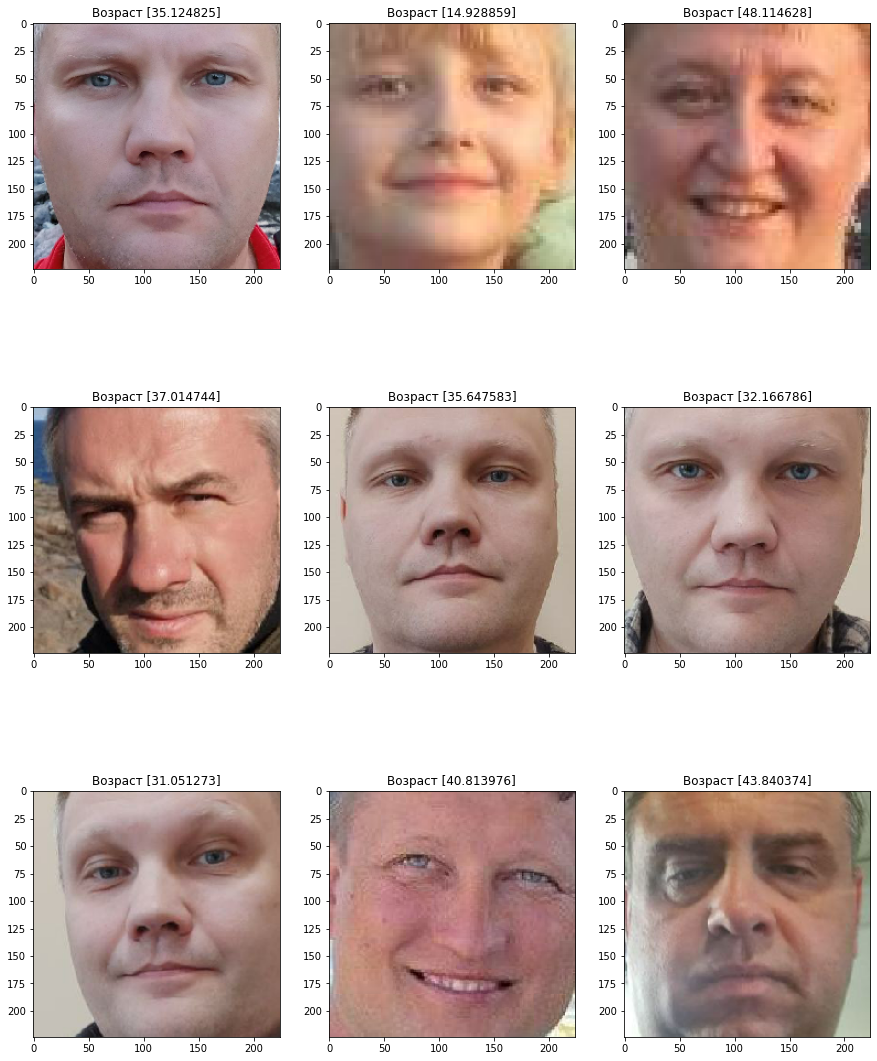

In [52]:
# Вывод на экран 9 фотографий
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,20))

n = 0
for ax in axes.flat:
    ax.set(title=(f'Возраст {predictions[n]}'))
    image = my_datagen[0][0][n]
    ax.imshow(image)
    n += 1
    if n == len(predictions):
        break
plt.show()

In [53]:
# Сохраняем модель для дальнейшего использования
model_all.save('/kaggle/working/my_cnn_fr_1.h5')

## Анализ обученной модели

Была поставлена задача создания модели, которая по фотографии определит приблизительный возраст человека.

Сначала был произведён анализ представленного датасета. Проблем и ошибок, мешающих созданию модели по имеемым данным выявлено небыло. Были выявлены факторы, которые могли быть причиной снижения качества модели: малое количество фотографий лиц старшего возраста и наличие фотографий, на которых лицо занимает малую часть фотографии.

Для решения проблемы с качеством имеемых фотографий была применена модель детекции лиц. Примерно 5 процентов фотографий было отбраковано, но на оставшихся остались только вырезаные лица. Думаю, что это сказалось на качестве обученной модели.

Создание модели с нуля могло-бы занять большое количество времени(и не гарантировало-бы результат). Поэтому было принято решение создавать модель на основе извесных архитектур имеемых в библиотеке Keras. Выбор архитектуры ResNet50 обусловлен тем, что модели на её основе вполне по плечу решение поставленной задачи, и при этом время решения и вычислительная нагрузка будет лежать в разумных пределах. Последние два слоя модели ResNet50 были заменены на три слоя, наиболее подходящих под задачу.

Созданная модель показала достаточное качество со значением MAE = 5.8. Таким образом можно сделать вывод, что задача создания модели определения приблизительного возраста человека по фотографии решена.

Работа модели на личных фотографиях показала работоспособность модели.
